In [28]:
# jinja2: remove_input
import sys
from pathlib import Path
import pandas as pd
from datasetsforecast.m3 import M3
import numpy as np
import os
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

project_root = Path(r"C:\Users\Utilizador\Desktop\Faculdade\Projeto Investigação - Séries Temporais\EasyTest")

sys.path.append(str(project_root / "src"))

from metrics import Pelt, STLFeatures, ACF_Features, LinearRegression

# ...

In [ ]:
print(f"\nLoading M3 Monthly data directly using datasetsforecast...")

if 'project_root' not in locals():
     current_dir = os.getcwd()
     project_root = os.path.dirname(current_dir)
     print(f"Defining project_root as: {project_root}")

data_dir = os.path.join(project_root, 'data', 'm3_monthly') # Specific subdir for clarity

# Ensure the data directory exists before loading
os.makedirs(data_dir, exist_ok=True)
print(f"Ensuring data directory exists/created: '{data_dir}'")

# Load data, providing the required directory argument
loaded_data = M3.load(directory=data_dir, group='Monthly')

# Process the loaded data (assuming it returns list/tuple or DataFrame)
if isinstance(loaded_data, (list, tuple)) and len(loaded_data) > 0:
    Y_df = loaded_data[0]
elif isinstance(loaded_data, pd.DataFrame):
    Y_df = loaded_data
else:
    # Handle unexpected load result without try-except - will likely cause error later
    print(f"Warning: Unexpected data type loaded: {type(loaded_data)}")
    Y_df = None

if Y_df is not None:
    print("Data loaded successfully.")
    print(f"DataFrame shape: {Y_df.shape}")
    Y_df['ds'] = pd.to_datetime(Y_df['ds'])
    print("DataFrame 'ds' column converted to datetime.")
    DATA_LOADED = True 
else:
    print("Failed to load data into DataFrame.")
    DATA_LOADED = False

In [20]:
extreme_datasets_info = None
CALCULATORS_DEFINED = False

if 'Pelt' in locals() and 'STLFeatures' in locals() and 'ACF_Features' in locals() and 'LinearRegression' in locals():

    pelt_calculator = Pelt() # Uses model="l2", min_size=2, jump=5
    stl_calculator = STLFeatures(freq=12)
    acf_calculator = ACF_Features(freq=12)
    lr_calculator = LinearRegression()

    extreme_datasets_info = {
        "Pelt_Num_Breakpoints": {
            "low_id": extreme_results_from_script["Pelt_Num_Breakpoints"]["lowest"][0],
            "high_id": extreme_results_from_script["Pelt_Num_Breakpoints"]["highest"][0],
            "calculator": pelt_calculator,
            "params": {"pen": None}
        },
        "STL_Trend_Strength": {
            "low_id": extreme_results_from_script["STL_Trend_Strength"]["lowest"][0],
            "high_id": extreme_results_from_script["STL_Trend_Strength"]["highest"][0],
            "calculator": stl_calculator,
             "params": {}
        },
        "ACF_FirstLag": {
            "low_id": extreme_results_from_script["ACF_FirstLag"]["lowest"][0],
            "high_id": extreme_results_from_script["ACF_FirstLag"]["highest"][0],
            "calculator": acf_calculator,
            "params": {}
        },
        "LinearRegression_Slope": {
            "low_id": extreme_results_from_script["LinearRegression_Slope"]["lowest"][0],
            "high_id": extreme_results_from_script["LinearRegression_Slope"]["highest"][0],
            "calculator": lr_calculator,
            "params": {}
        },
        "LinearRegression_R2": {
            "low_id": extreme_results_from_script["LinearRegression_R2"]["lowest"][0],
            "high_id": extreme_results_from_script["LinearRegression_R2"]["highest"][0],
            "calculator": lr_calculator, 
            "params": {}
        },
    }

    CALCULATORS_DEFINED = True

## Pelt_Num_Breakpoints

This feature detects the number of points where the trend changes. A low value means the trend has few/none shifting points, and is constant through time, while a high value means the trend is constantly shifting, provoking many estrutural changes.

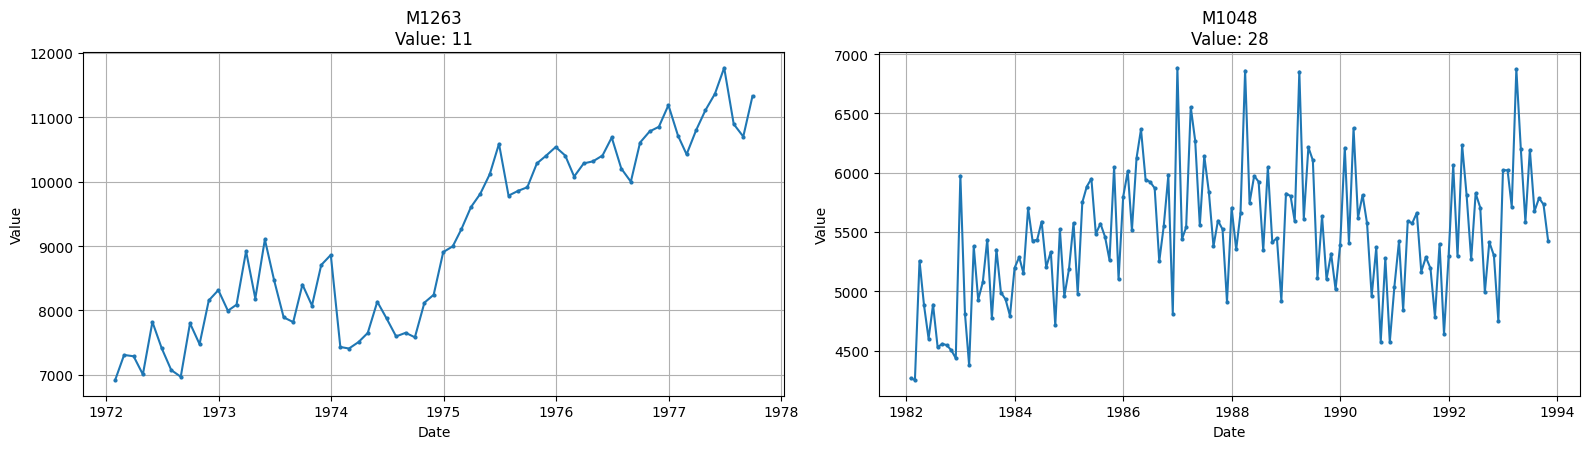

## STL_Trend_Strength

This feature computes the strenght of a trend within the time-series. A low value (close to zero) means there are few/none indicators of a trend in the time series while a high value (close to one) means there are strong signs of the series containing a trend.

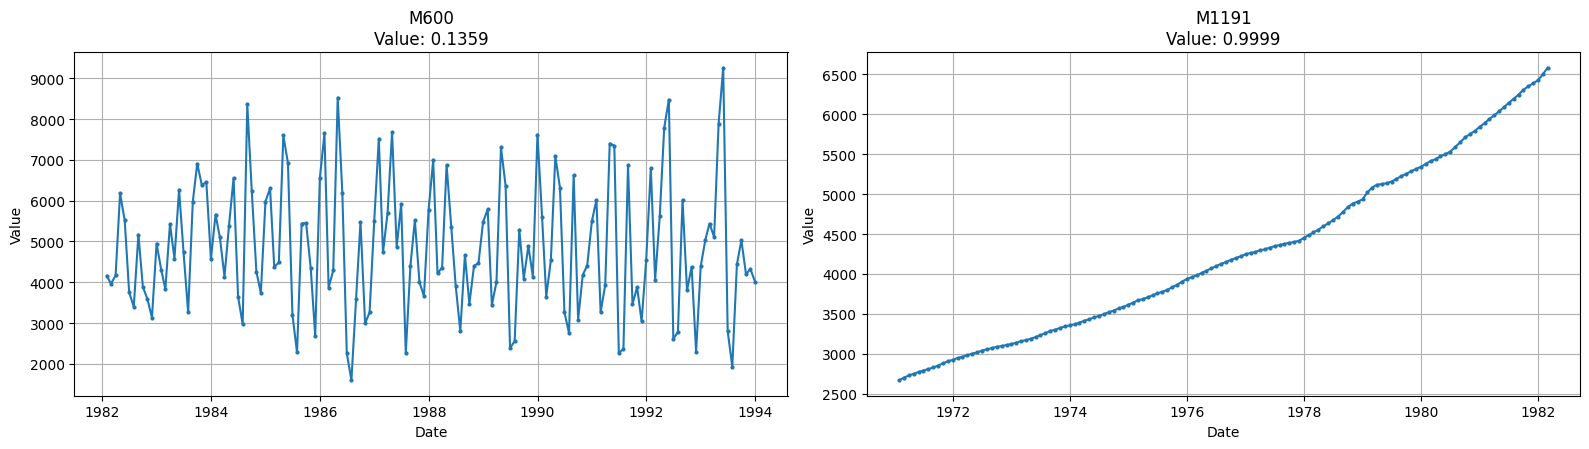

## ACF_FirstLag

This feature measures the first 1/e crossing of the auto-correlation function, which means a low/negative value indicates negative auto-correlation while a high/positive value indicates strong auto-correlation.

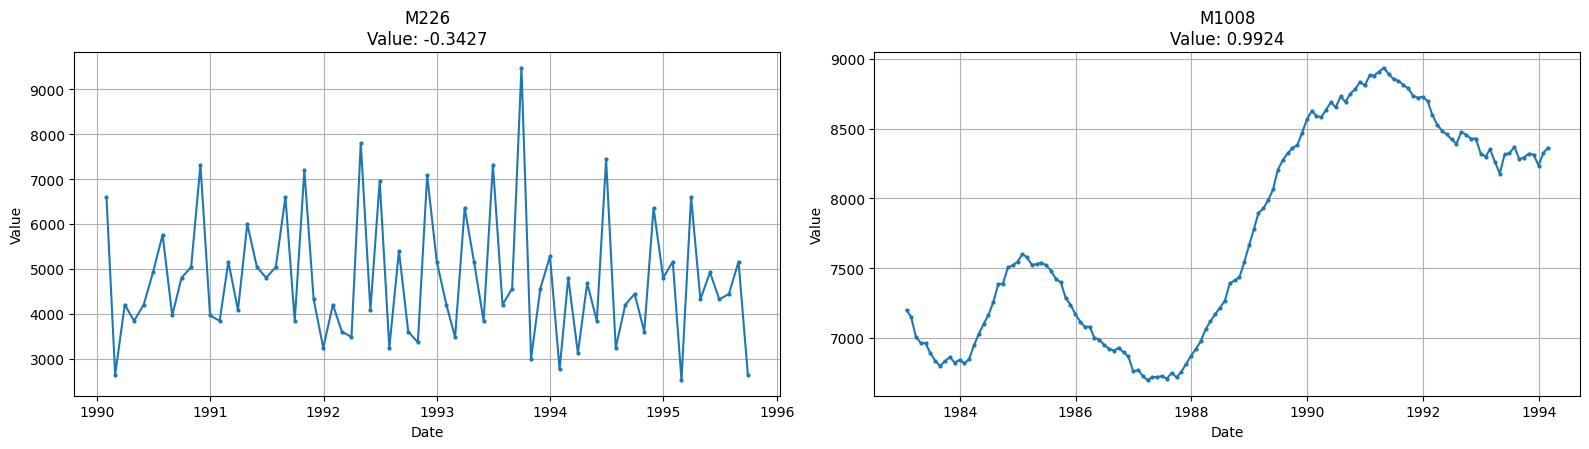

## LinearRegression_Slope

This feature measures the overall linear trend. A low/negative value means there is a strong downward trend while a high/positive value means a strong upward trend.

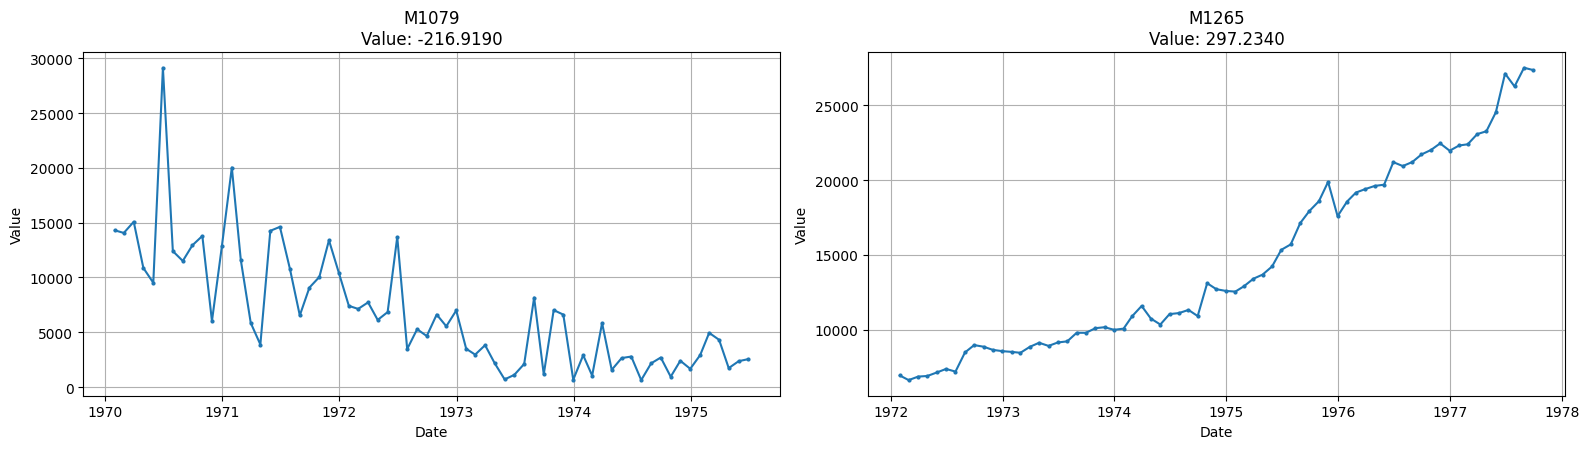

## LinearRegression_R2

This feature measures the linear fit of a time-series. A low value (close to zero) means few/none linear fit while a high value (close to one) means a high linear fit.

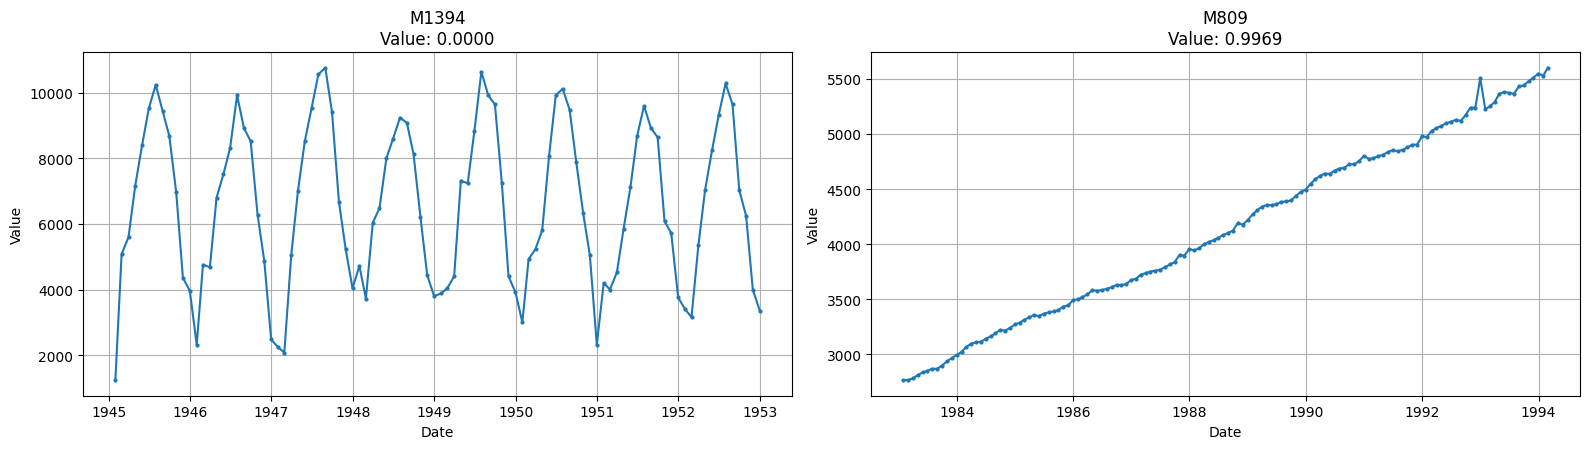

In [38]:
for feature_name, details in extreme_datasets_info.items():
    display(Markdown(f"## {feature_name}"))

    ids_to_process = {
        "Lowest Value": details["low_id"],
        "Highest Value": details["high_id"]
    }
    calculator = details["calculator"]
    params = details["params"]

    if feature_name == "Pelt_Num_Breakpoints":
        display(Markdown(f"This feature detects the number of points where the trend changes. A low value means the trend has few/none shifting points, and is constant through time, while a high value means the trend is constantly shifting, provoking many estrutural changes."))
    elif feature_name == "STL_Trend_Strength":
        display(Markdown(f"This feature computes the strenght of a trend within the time-series. A low value (close to zero) means there are few/none indicators of a trend in the time series while a high value (close to one) means there are strong signs of the series containing a trend."))
    elif feature_name == "ACF_FirstLag":
        display(Markdown(f"This feature measures the first 1/e crossing of the auto-correlation function, which means a low/negative value indicates negative auto-correlation while a high/positive value indicates strong auto-correlation."))
    elif feature_name == "LinearRegression_Slope":
        display(Markdown(f"This feature measures the overall linear trend. A low/negative value means there is a strong downward trend while a high/positive value means a strong upward trend."))
    elif feature_name == "LinearRegression_R2":
        display(Markdown(f"This feature measures the linear fit of a time-series. A low value (close to zero) means few/none linear fit while a high value (close to one) means a high linear fit."))

    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    feature_values = {} # Store values for titles

    for i, (desc, target_id) in enumerate(ids_to_process.items()):
        ax = axes[i]
        series_df = Y_df[Y_df['unique_id'] == target_id].sort_values('ds')

        if series_df.empty:
            print(f"Dataset {target_id} not found or empty. Skipping plot for {desc}.")
            ax.set_title(f"{target_id} (Data missing)") # Changed line
            ax.text(0.5, 0.5, 'Data Missing', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
            continue

        series_np = series_df['y'].to_numpy()

        if len(series_np) < 2:
            print(f"Dataset {target_id} too short (len<2). Skipping plot for {desc}.")
            ax.set_title(f"{target_id} (Too short)") # Changed line
            ax.text(0.5, 0.5, 'Series Too Short', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
            continue

        feature_value = np.nan

        if feature_name == "Pelt_Num_Breakpoints":
            min_len_pelt = getattr(calculator, 'min_size', 2)
            if len(series_np) >= min_len_pelt and len(series_np) > 1:
                pen_value = np.log(len(series_np))
                calculator.fit(series_np)
                bkps = calculator.predict(pen=pen_value)
                num_changepoints = len(bkps) - 1 if bkps else 0
                feature_value = max(0, num_changepoints)
            else:
                print(f"Skipping Pelt calculation for {target_id}")
        elif feature_name == "STL_Trend_Strength":
            min_len_stl = 2 * getattr(calculator, 'freq', 12) + 1
            if len(series_np) >= min_len_stl:
                stl_result = calculator.get_features(x=series_np)
                feature_value = stl_result.get('trend', np.nan)
            else:
                print(f"Skipping STL calculation for {target_id}")
        elif feature_name == "ACF_FirstLag":
            acf_result = calculator.get_features(x=series_np)
            feature_value = acf_result.get('x_acf1', np.nan)
        elif feature_name == "LinearRegression_Slope":
            lr_model = LinearRegression() # Use correct class name if changed
            lr_model.fit(time_series=series_np)
            feature_value = lr_model.coef_
        elif feature_name == "LinearRegression_R2":
            lr_model = LinearRegression() # Use correct class name if changed
            lr_model.fit(time_series=series_np)
            feature_value = lr_model.score()

        feature_values[desc] = feature_value

        ax.plot(series_df['ds'], series_np, marker='.', linestyle='-', markersize=4)

        # --- THIS IS THE SINGLE ALTERED LINE ---
        subplot_title = f"{target_id}" # Changed line: Removed the "{desc}: " prefix
        # --- END OF SINGLE ALTERED LINE ---

        if feature_value is not None and not np.isnan(feature_value):
             if feature_name == "Pelt_Num_Breakpoints":
                  subplot_title += f"\nValue: {int(feature_value)}"
             else:
                  subplot_title += f"\nValue: {feature_value:.4f}"
        else:
             subplot_title += f"\nValue: Calc Failed/Skipped"
        ax.set_title(subplot_title)
        ax.set_xlabel("Date")
        ax.set_ylabel("Value")
        ax.grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()